# ETL Pipeline Preparation
Follow the instructions below to help you create your ETL pipeline.
### 1. Import libraries and load datasets.
- Import Python libraries
- Load `messages.csv` into a dataframe and inspect the first few lines.
- Load `categories.csv` into a dataframe and inspect the first few lines.

In [2]:
# import libraries
import numpy as np
import pandas as pd
import json
from sklearn.metrics import confusion_matrix, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [3]:
# load messages dataset
messages = pd.read_csv(".//data//disaster_messages.csv")
messages.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [4]:
# load categories dataset
categories = pd.read_csv('.//data//disaster_categories.csv')
categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


### 2. Merge datasets.
- Merge the messages and categories datasets using the common id
- Assign this combined dataset to `df`, which will be cleaned in the following steps

In [5]:
# merge datasets
df = pd.merge(messages, categories, on = 'id')
df.head()

,id,message,original,genre,categories
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,related-1;request-0;offer-0;aid_related-0;medi...
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,related-1;request-0;offer-0;aid_related-1;medi...
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,related-1;request-0;offer-0;aid_related-0;medi...
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,related-1;request-1;offer-0;aid_related-1;medi...
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,related-1;request-0;offer-0;aid_related-0;medi...


### 3. Split `categories` into separate category columns.
- Split the values in the `categories` column on the `;` character so that each value becomes a separate column. You'll find [this method](https://pandas.pydata.org/pandas-docs/version/0.23/generated/pandas.Series.str.split.html) very helpful! Make sure to set `expand=True`.
- Use the first row of categories dataframe to create column names for the categories data.
- Rename columns of `categories` with new column names.

In [6]:
# create a dataframe of the 36 individual category columns
categories = df['categories'].str.split(pat = ";", expand = True)
categories.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [7]:
# select the first row of the categories dataframe
row = categories.iloc[0, :]
#  extract a list of new column names for categories.
category_colnames = row.apply(lambda x:x.split('-')[0]).values.tolist()
print(category_colnames)

['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'child_alone', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']


In [8]:
# rename the columns of `categories`
categories.columns = category_colnames
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


### 4. Convert category values to just numbers 0 or 1.
- Iterate through the category columns in df to keep only the last character of each string (the 1 or 0). For example, `related-0` becomes `0`, `related-1` becomes `1`. Convert the string to a numeric value.
- You can perform [normal string actions on Pandas Series](https://pandas.pydata.org/pandas-docs/stable/text.html#indexing-with-str), like indexing, by including `.str` after the Series. You may need to first convert the Series to be of type string, which you can do with `astype(str)`.

In [9]:
for column in categories:
    # set each value to be the last character of the string
    categories[column] = categories[column].apply(lambda x:x.split('-')[1])
    
    # convert column from string to numeric
    categories[column] = categories[column].astype(int)
categories.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 5. Replace `categories` column in `df` with new category columns.
- Drop the categories column from the df dataframe since it is no longer needed.
- Concatenate df and categories data frames.

In [10]:
# drop the original categories column from `df`
df.drop('categories', axis=1, inplace=True)
df.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [11]:
# concatenate the original dataframe with the new `categories` dataframe
df = pd.concat([df,categories], axis=1)
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 6. Remove duplicates.
- Check how many duplicates are in this dataset.
- Drop the duplicates.
- Confirm duplicates were removed.

In [12]:
# check number of duplicates
df.duplicated().sum()

170

In [13]:
# drop duplicates
df.drop_duplicates(inplace=True)

In [14]:
# check number of duplicates
df.duplicated().sum()

0

In [25]:
categories = []
messages_count = []
for col in df.iloc[:,4:].columns:
    categories.append(col)
    messages_count.append(df[col].sum())


<Container object of 36 artists>

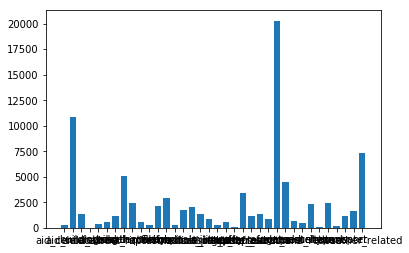

In [26]:
plt.bar(x_)

### 7. Save the clean dataset into an sqlite database.
You can do this with pandas [`to_sql` method](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.to_sql.html) combined with the SQLAlchemy library. Remember to import SQLAlchemy's `create_engine` in the first cell of this notebook to use it below.

In [16]:
engine = create_engine('sqlite:///messages.db')
df.to_sql('messages', engine, index=False)

### 8. Use this notebook to complete `etl_pipeline.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database based on new datasets specified by the user. Alternatively, you can complete `etl_pipeline.py` in the classroom on the `Project Workspace IDE` coming later.

In [69]:
def etl_pipeline(csv1 = 'messages.csv', csv2 = 'categories.csv', database = 'disaster-response-messages.db', sqltable = 'messages'):
    """
    
    """
    #read the two files
    messages = pd.read_csv(csv1)
    categories = pd.read_csv(csv2)
    
    #merge the two dataframes on id
    df = pd.merge(messages, categories, on = 'id')
    
    # create a dataframe of the 36 individual category columns
    categories = df['categories'].str.split(pat = ";", expand = True)
    
    # select the first row of the categories dataframe
    row = categories.iloc[0, :]
    # use this row to extract a list of new column names for categories.
    # one way is to apply a lambda function that takes everything 
    # up to the second to last character of each string with slicing
    category_colnames = row.apply(lambda x:x.split('-')[0]).values.tolist()
    
    # rename the columns of `categories`
    categories.columns = category_colnames
    
    for column in categories:
        # set each value to be the last character of the string
        categories[column] = categories[column].apply(lambda x:x.split('-')[1])
    
        # convert column from string to numeric
        categories[column] = categories[column].astype(int)
        
    # drop the original categories column from `df`
    df.drop('categories', axis=1, inplace=True)    
    
    # concatenate the original dataframe with the new `categories` dataframe
    df = pd.concat([df,categories], axis=1)

    # drop duplicates
    df.drop_duplicates(inplace=True)
    
    engine = create_engine('sqlite:///'+database)
    df.to_sql(sqltable, engine, index=False)

    
    

In [70]:
etl_pipeline()